In [1]:
import compute_charge_dist as fz
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

import PeHeat_Functions as peh
import parametric_fz as fzpar
import dust_size_dist as sizedist

import yt
from yt.units import pc, kpc, second, Kelvin, gram, erg, cm

import MCMCFit as mcmc

%matplotlib inline

microntocm    = 1.0e-4
cmtomicron    = 1.0e4
AAtocm        = 1.0e-8
cmtoAA        = 1.0e8
microntoAA    = 1.0e4
AAtomicron    = 1.0e-4
ergtoeV       = 6.242e11
eVtoerg       = 1.602e-12

hplanck       = 4.135667662e-15 # eV s
clight        = 2.99792458e10   # cm s-1

Loading the library to compute the charge distribution of dust grains.


In [2]:
# Define some constant parameters to be used.
mp      = 1.6726e-24  * gram # g
mH      = 1.6733e-24  * gram
mC      = 12.011*mH
#mu      = 1.2924
kb      = 1.3806e-16  *erg / Kelvin # erg K-1
GNewton = 6.6743e-8   * cm**3 / (gram * second**2 )# cm3 g-1 s-2
Msun    = 1.9884e33   * gram
#mm      = mu*mp

ppc = 3.0856776e18

# -------------------------------------------------------------
#              Create a lot of new derived fields
# -------------------------------------------------------------

# Create a derived field.
# Hydrogen number density
def numdensH(field, data): 
    nH = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    return nH

# Molecular Hydrogen number density
def numdensH2(field, data): 
    nH2 = data["dens"]*(data["ih2 "])/(1.4*mH)
    return nH2

# Carbon number density
def numdensC(field, data): 
    nC = data["dens"]*(data["icp "]+data["ico "])/(1.4*mC)
    return nC

# electron number density
def numdense(field, data): 
    ne = data["dens"]*(data["ihp "]/(1.4*mH) + data["icp "]/(1.4*mC))
    return ne

# Ionized hydrogen fraction
def xHp(field, data): 
    nH  = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    xHp = data["dens"]*data["ihp "]/(1.4*mH)
    xHp = xHp / nH
    return xHp

# Molecular hydrogen fraction
def xH2(field, data): 
    nH  = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    xH2 = data["dens"]*data["ih2 "]/(1.4*mH)
    xH2 = xH2 / nH
    return xH2

# Ionized carbon fraction
def xCp(field, data): 
    nC  = data["dens"]*(data["icp "]+data["ico "])/(1.4*mC)
    xCp = data["dens"]*data["icp "]/(1.4*mC) / nC
    return xCp

# electron fraction
def xe(field, data): 
    nH = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    nC = data["dens"]*(data["icp "]+data["ico "])/(1.4*mC)
    ne = data["dens"]*(data["ihp "]/(1.4*mH) + data["icp "]/(1.4*mC))
    xe = ne / (nH + nC)
    return xe

# electron fraction
#def GG(field, data): 
#    G = fz.get_G(data["cdto"], 1.68)
#    return G


yt.add_field('nH', function=numdensH,  units="1/cm**3", force_override=True)
yt.add_field('nH2',function=numdensH2, units="1/cm**3", force_override=True)
yt.add_field('nC', function=numdensC,  units="1/cm**3", force_override=True)
yt.add_field('ne', function=numdense,  units="1/cm**3", force_override=True)
yt.add_field('xHp', function=xHp,      units="dimensionless", force_override=True)
yt.add_field('xH2', function=xH2,      units="dimensionless", force_override=True)
yt.add_field('xCp', function=xCp,      units="dimensionless", force_override=True)
yt.add_field('xe', function=xe,        units="dimensionless", force_override=True)
#yt.add_field('G',  function=GG,        units="dimensionless", force_override=True)

/Users/juan/anaconda/lib/python2.7/site-packages/yt/fields/local_fields.py:46: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  warnings.warn("Because 'sampling_type' not specified, yt will "


In [3]:
# Input variables.
#data_dir   = "/home/jcibanezm/codes/run/Silcc/CF_Prabesh"
data_dir   = "/Users/juan/codes/run/Silcc/CF_Prabesh"
filename   = data_dir + "/NL99_R8_cf_hdf5_chk_0028"

pf = yt.load("%s"%(filename))

c  = [0,0,0]
le = [-4.93696000e+19, -4.93696000e+19, -4.93696000e+19]
re = [ 4.93696000e+19,  4.93696000e+19,  4.93696000e+19]

box = pf.box(le, re)

min_dens = np.min(box["density"])
max_dens = np.max(box["density"])

min_nh   = np.min(box["nH"])
max_nh   = np.max(box["nH"])

min_temp = np.min(box["temperature"])
max_temp = np.max(box["temperature"])

min_ne = np.min(box["ne"])
max_ne = np.max(box["ne"])

min_xe = np.min(box["xe"])
max_xe = np.max(box["xe"])

min_Av = np.min(box["cdto"])
max_Av = np.max(box["cdto"])

yt : [INFO     ] 2018-12-24 19:22:38,550 Particle file found: NL99_R8_cf_hdf5_chk_0028
yt : [INFO     ] 2018-12-24 19:22:38,571 integer runtime parameter checkpointfilenumber overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-12-24 19:22:38,573 integer runtime parameter forcedplotfilenumber overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-12-24 19:22:38,575 integer runtime parameter nbegin overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-12-24 19:22:38,578 integer runtime parameter plotfilenumber overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-12-24 19:22:38,638 Parameters: current_time              = 5.68049127342e+14
yt : [INFO     ] 2018-12-24 19:22:38,640 Parameters: domain_dimensions         = [32  8  8]
yt : [INFO     ] 2018-12-24 19:22:38,643 Parameters: domain_left_edge          = [ -1.97478400e+20  -4.93696000e+19  -4.93696000e+19]
yt : [INFO     ] 2018-12-24 19:22:38,645 Parameters: domain_righ

In [4]:
wnm = ((box["temperature"].in_units("K") > 6.0e3)&(box["temperature"].in_units("K") < 1.0e4)&(box["iha "] > 0.6)&(box["nH"] >= 0.75))
cnm = ((box["temperature"].in_units("K") > 50)   &(box["temperature"].in_units("K") < 70)   &(box["iha "] > 0.6))
cmm = ((box["temperature"].in_units("K") < 50)   &(box["ih2 "] > 0.6) &(box["nH"] <3.0e4))

wnmtrue = np.argwhere(wnm==True)
cnmtrue = np.argwhere(cnm==True)
cmmtrue = np.argwhere(cmm==True)

wnmindex = wnmtrue[0]
#wnmindex = [3626974]
cnmindex = cnmtrue[0]
#cmmindex = cmmtrue[3626974]
cmmindex = [3479445]

In [5]:
indexarr = np.array([wnmindex, cnmindex, cmmindex])

temp= np.array( box["temp"][indexarr])
dd  = np.array( box["dens"][indexarr])
nH  = np.array( box["nH"]  [indexarr])
nH2 = np.array( box["nH2"]  [indexarr])
nC  = np.array( box["nC"]  [indexarr])
ne  = np.array( box["ne"]  [indexarr])
xe  = np.array( box["xe"]  [indexarr])
xHp = np.array( box["xHp"]  [indexarr])
xH2 = np.array( box["xH2"]  [indexarr])
xCp = np.array( box["xCp"]  [indexarr])
Av  = np.array( box["cdto"][indexarr])
fH2shield  = np.array( box["cdh2"][indexarr])

G0 = 1.7
Ntot =  Av * 1.87e21

GG = [fz.get_G(Ntot[0], G0=G0), fz.get_G(Ntot[1], G0=G0), fz.get_G(Ntot[2], G0=G0)]

NH2 = np.zeros_like(nH2)
for i in range(3):
    NH2[i] = fz.get_NH2(fH2shield[i], temp[i])

zeta_cmm = fz.get_zeta(NH2[2])
ne_cmm, xe_cmm    = fz.compute_new_xe([nH[2], nC[2]], [xe[2], xCp[2]], xH2[2], zeta=zeta_cmm)

xe[2] = xe_cmm
ne[2] = nH[2]*xe_cmm

for i in range(3):
    G_CR = fz.get_G_CR(NH2[i])
    
Gtot = GG + G_CR

$$ \Gamma^{''}_{\mathrm{pe}}(a, Z, G) = \Gamma_0 \mathrm{\; erg \; s^{-1}} \left( \frac{G}{1.7} \right) \left( \frac{a}{5 A} \right)^{\alpha} \mathrm{exp}(-\zeta Z) $$

Silicates
$$ \zeta(a) = 2.95 \, \left(\frac{a}{5 A}\right)^{-1.04}$$

$$ \Gamma_0 = 2.3 \times 10^{-20} $$

Carbonaceous
$$ \Gamma_0 = 4.07 \times 10^{-20} $$

$$ f(Z) = \frac{1}{\sqrt{2\pi \sigma_{Z}^{2}}} \; \mathrm{exp}\left( - \frac{(Z - \langle Z \rangle)^{2}}{2\sigma_{Z}^{2}} \right)$$


---

In [14]:
import parametric_PeHeat as peh

---

In [18]:
# Check the integration of the size distribution.
from scipy.integrate import simps

# using quad integration from scipy.
totd_s = integrate.quad(lambda x:sizedist.dnda(x, "silicate"), 3.5, 2500)
totd_c = integrate.quad(lambda x:sizedist.dnda(x, "carbonaceous"), 3.5, 2500)

print("Total silicate grain density     ", totd_s)
print("Total carbonaceous grain density ", totd_c)

# Integration using simpsons rule. 
x = np.logspace(np.log10(3.5), np.log10(2500), num=50)
yc = sizedist.dnda(x, "carbonaceous")
ys = sizedist.dnda(x, "silicate")

yc2, ys2 =np.zeros_like(yc), np.zeros_like(ys)
for i in range(len(x)):
    yc2[i] = sizedist.dnda(x[i], "carbonaceous")
    ys2[i] = sizedist.dnda(x[i], "silicate")
    
totd_s_fix = simps(ys, x)
totd_c_fix = simps(yc, x)

print("--------------------------------------------")
print("Relative accuracy between integration using:")
print("simpson / quad.")
print("Carbonaceous ", totd_c_fix/totd_c[0])
print("Silicates    ", totd_s_fix/totd_s[0])

('Total silicate grain density     ', (3.616394874572037e-08, 7.798648719395752e-09))
('Total carbonaceous grain density ', (6.196919970329322e-07, 1.1219924933897294e-09))
-----------------------------
simpson / quad.
('Carbonaceous ', 0.99911776192807711)
('Silicates    ', 1.0027634362549478)


---

In [19]:
vec_Gammadot = np.vectorize(peh.get_Gamma_dot)

In [51]:
# Compare integration of the photoelectric heating

amin, amax = 2.0, 3000
fheat = lambda grain_size, Gtot, T, ne, grain_type: 1.0e21*peh.get_Gamma_dot(Gtot, T, ne, grain_size, grain_type)*sizedist.dnda(grain_size, grain_type)
    
Gamma_pe_sil,  err = integrate.quad(fheat, amin, amax, args=(Gtot[2], temp[2], ne[2], "silicate"))
Gamma_pe_carb, err = integrate.quad(fheat, amin, amax, args=(Gtot[2], temp[2], ne[2], "carbonaceous"))

x  = np.logspace(np.log10(amin), np.log10(amax), num=50)
yc = sizedist.dnda(x, "carbonaceous")
ys = sizedist.dnda(x, "silicate")

y_Gpe_s = vec_Gammadot(Gtot[2], temp[2], ne[2], x, "silicate")*ys*1.0e21
y_Gpe_c = vec_Gammadot(Gtot[2], temp[2], ne[2], x, "carbonaceous")*yc*1.0e21

Gamma_pe_sil_fix = simps(y_Gpe_s, x)
Gamma_pe_carb_fix = simps(y_Gpe_c, x)

print("--------------------------------------")
#print(Gamma_pe_sil, Gamma_pe_sil_fix, Gamma_pe_sil/Gamma_pe_sil_fix)
#print(Gamma_pe_carb, Gamma_pe_carb_fix, Gamma_pe_carb/Gamma_pe_carb_fix)
#print(Gamma_pe_sil+Gamma_pe_carb, Gamma_pe_sil_fix+Gamma_pe_carb_fix, (Gamma_pe_sil+Gamma_pe_carb)/(Gamma_pe_sil_fix+Gamma_pe_carb_fix))
print("Silicates   ", Gamma_pe_sil/Gamma_pe_sil_fix)
print("Carbonaceous", Gamma_pe_carb/Gamma_pe_carb_fix)
print("Total       ", (Gamma_pe_sil+Gamma_pe_carb)/(Gamma_pe_sil_fix+Gamma_pe_carb_fix))

--------------------------------------
('Silicates   ', 1.1025895179242642)
('Carbonaceous', 1.1463870885571896)
('Total       ', 1.135556146039453)


In [65]:
Gamma_tot_k = np.zeros(50, dtype=np.float)
trapz_s = np.zeros(50, dtype=np.float)
trapz_c = np.zeros(50, dtype=np.float)
trapz_s_cumul = np.zeros(50, dtype=np.float)
trapz_c_cumul = np.zeros(50, dtype=np.float)

deltax  = np.zeros(50, dtype=np.float) 

k=1
while k < 50:
    deltax[k-1] = x[k] - x[k-1]
    trapz_s[k-1] = (y_Gpe_s[k-1] + y_Gpe_s[k])/2.0*deltax[k-1]
    trapz_s_cumul[k-1] = np.sum(trapz_s[0:k])
    trapz_c_cumul[k-1] = np.sum(trapz_c[0:k])
    trapz_c[k-1] = (y_Gpe_c[k-1] + y_Gpe_c[k])/2.0*deltax[k-1]
    Gamma_tot_k[k-1] = (y_Gpe_s[k-1] + y_Gpe_s[k])/2.0*deltax[k-1] + (y_Gpe_c[k-1] + y_Gpe_c[k])/2.0*deltax[k-1]
    k+=1

In [66]:
print(np.sum(trapz_s) / Gamma_pe_sil)
print(np.sum(trapz_c) / Gamma_pe_carb)
print(np.sum(Gamma_tot_k) / (Gamma_pe_sil+Gamma_pe_carb))
print(trapz_c_cumul[-2]/ Gamma_pe_carb)
print(trapz_s_cumul[-2]/ Gamma_pe_sil)

0.909712125697
0.875580931634
0.883776384532
0.874542460663
0.909712125697


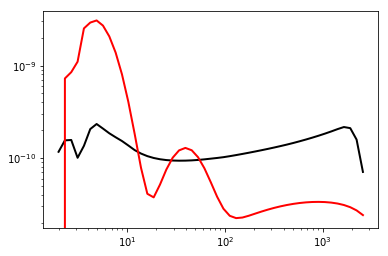

In [54]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x[0:49], trapz_s[0:49], "-k", linewidth=2)
ax.plot(x[0:49], trapz_c[0:49], "-r", linewidth=2)
ax.set_xscale("log")
ax.set_yscale("log")
fig.show()

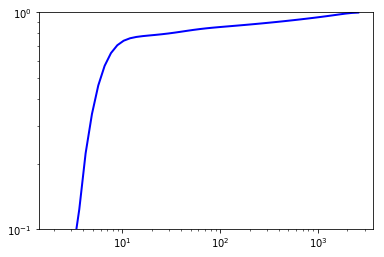

In [70]:
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.plot(x[0:49], trapz_s_cumul[0:49], "-k", linewidth=2)
#ax.plot(x[0:49], trapz_c_cumul[0:49], "-r", linewidth=2)
ax.plot(x[0:49], (trapz_c_cumul[0:49]+trapz_s_cumul[0:49])/np.sum(Gamma_tot_k), "-b", linewidth=2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(0.1, 1.01)
fig.show()

In [278]:
def get_Gamma_tot_FixInt(amin, amax, numint=50):

    x = np.logspace(np.log10(amin), np.log10(amax), num=numint)
    yc = sizedist.dnda(x, "carbonaceous")
    ys = sizedist.dnda(x, "silicate")

    y_Gpe_s = vec_Gammadot(Gtot[1], temp[1], ne[1], x, "silicate")*ys*1.0e21
    y_Gpe_c = vec_Gammadot(Gtot[1], temp[1], ne[1], x, "carbonaceous")*yc*1.0e21

    Gamma_pe_sil_fix = simps(y_Gpe_s, x)
    Gamma_pe_carb_fix = simps(y_Gpe_c, x)
    
    Gamma_tot= Gamma_pe_sil_fix + Gamma_pe_carb_fix
    
    return Gamma_tot

In [279]:
Gtt0 = get_Gamma_tot(Gtot[1], temp[1], ne[1])

In [280]:
Gttfix = get_Gamma_tot_FixInt(3.5, 2500, numint=20)

print("Relative diff", abs((Gtt0 - Gttfix)/Gtt0*100.))

('Relative diff', 0.3514510586821726)


---

# Now, the full calculation of the photoelectric heating.

In [12]:
NH2 = np.zeros_like(nH)
for i in range(3):
    NH2[i] = fz.get_NH2(fH2shield[i], temp[i])

In [46]:
phase = 0
grain_size = 5.0
grain_type = "silicate"


def netHeating_full(grain_size, grain_type, nH, temp, xe, xH2, Ntot, NH2, G0=1.7, save_output=False, outdir="default", pedantic=False):
    """
    Perform the full calculation of the net heating by a single grain given the ISM ambient parameters.
    """
    import cPickle as pickle
    import compute_charge_dist as fz
    import numpy as np
    import PeHeat_Functions as peh
    
    #Full calculation of the net heating by a grain at a given cell.
    Qabs = fz.get_QabsTable(grain_type, grain_size)

    #print("Running grain size %i, "%(grain_size))

    zeta = fz.get_zeta(NH2)

    # Compute the charge distribution.
    ############################################################################################
    Jpe, Je, Jh, Jc, ZZall = fz.compute_currents ([nH, nH*1.0e-4], [xe, 1.0e4*min(xe, 1.0e-4)], xH2, temp, zeta, grain_size, Ntot, grain_type, Qabs, G0=G0)
    JCRe, JCRpe, ZZnew     = fz.compute_CR_currents(nH, zeta, grain_size, grain_type, Qabs)

    zeq                    = fz.get_zeq_vec      (Jpe, Je, Jh, Jc, ZZall, grain_size, grain_type)
    new_zmin, new_zmax     = fz.get_new_zmin_zmax([nH, nH*1.0e-4], [xe, 1.0e4*min(xe, 1.0e-4)], temp, grain_size, Ntot, grain_type, Qabs, zeta, zeq=zeq, G0=G0, includeCR=True)    
    
    ffzCR, ZZfz            = fz.vector_fz        (Jpe, Je, Jh, Jc, JCRe, JCRpe, ZZall, new_zmin, new_zmax, includeCR=True)

    # Compute the minimum and maximum allowd charges by this grain
    Zmin, Zmax = fz.get_Zmin(grain_size, grain_type), fz.get_Zmax(grain_size, grain_type)
    Znum       = int(Zmax + abs(Zmin) +1)
    ZZ_all     = np.linspace(Zmin, Zmax, num=Znum)

    Gamma_dotdot_Z = np.zeros_like(ZZ_all, dtype=np.float)

    for i in range(Znum):
        Gamma_dotdot_Z[i] = peh.get_Gamma_pe_dotdot(grain_size, ZZ_all[i], grain_type, Ntot, Qabs)    

    Cooling = peh.Cool_per_Grain(grain_size, grain_type, ZZfz, ffzCR, nH, xe, temp)

    Av = Ntot/1.87e21
    
    Geff = G0*np.exp(-2.5*Av)
    G_CR = fz.get_G_CR(NH2)
    
    Gtot = Geff+G_CR
    
    Heating = peh.Gamma_per_grain(ZZ_all, Gamma_dotdot_Z, ZZfz, ffzCR)

    netHeating = Heating - Cooling
    
    if save_output:
        if nH < 1.0:
            phase = "WNM"
        elif nH>1.0 and nH<100:
            phase = "CNM"
        else:
            phase = "CMM"
        
        if outdir == "default":
            outdir = "/home/jcibanezm/codes/run/PeHeat"
        
        if grain_size <= 12:
            filename = "%s/TotalHeating_ISM%s_%s_%.5iAA.pkl"%(outdir, phase, grain_type, grain_size*10.)
        else:
            filename = "%s/TotalHeating_ISM%s_%s_%.4iAA.pkl"%(outdir, phase, grain_type, grain_size)
    
        dictionary = {"info":"Saving the Heating, Cooling, charge array and charge distribution."}
        dictionary["netHeating"] = netHeating
        dictionary["Cooling"] = Cooling
        dictionary["grain_size"] = grain_size
        dictionary["grain_type"] = grain_type
        dictionary["ffz"] = ffzCR
        dictionary["ZZ"] = ZZfz
        dictionary["nH"] = nH
        dictionary["temp"] = temp
        dictionary["Geff"] = Geff
        dictionary["Gtot"] = Gtot
        dictionary["zeta"] = zeta
        dictionary["Ntot"] = Ntot
        dictionary["NH2"] = NH2
        dictionary["ne"] = nH*xe
        dictionary["xe"] = xe
        dictionary["xH2"] = xH2

        if pedantic == True:
            print("Saving a file with the information of the net Heating and Cooling in this cell.")
            print("Cell properties:")
            print("grain size = %.1f, grain type = %s"%(grain_size, grain_type))
            print("ntot = %.2g \t temp = %.2g \t Geff = %.2g \t Gtot = %.2g"%(nH, temp, Geff, Gtot))
            print("zeta = %.2g \t Ntot = %.2g \t NH2 = %.2g \t ne = %.2g"%(zeta, Ntot, NH2, nH*xe))
            print("xe = %.2g \t xH2 = %.2g"%(xe, xH2))
            print("netHeating = %.2g erg s-1  \t Cooling %.2g erg s-1"%(netHeating, Cooling))
            print("ZZ =", ZZfz)
            print("f(Z) = ",ffzCR)
        
        outfile = open('%s'%(filename), 'wb')
        pickle.dump(dictionary, outfile)
        outfile.close()
        
        #print("Saving the heating, cooling, charge array and charge distribution array to file %s"%filename)
    
    #return netHeating, Cooling, ZZfz, ffzCR
    return netHeating

In [31]:
netHeating_full(1993., "silicate", nH[1], temp[1], xe[1], xH2[1], Ntot[1], NH2[1], save_output=True, pedantic=True)
print("Done 1993 silicate")
netHeating_full(1993., "carbonaceous", nH[1], temp[1], xe[1], xH2[1], Ntot[1], NH2[1], save_output=True, pedantic=True)
print("Done 1993 carbonaceous")
netHeating_full(2499, "silicate", nH[1], temp[1], xe[1], xH2[1], Ntot[1], NH2[1], save_output=True, pedantic=True)
print("Done 1993 silicate")
netHeating_full(2499, "carbonaceous", nH[1], temp[1], xe[1], xH2[1], Ntot[1], NH2[1], save_output=True, pedantic=True)
print("Done 1993 carbonaceous")

I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
Saving a file with the information of the net Heating and Cooling in this cell.
Cell properties:
grain size = 3.5, grain type = silicate
ntot = 36 	 temp = 70 	 Geff = 0.6 	 Gtot = 0.6
zeta = 1.3e-15 	 Ntot = 7.8e+20 	 NH2 = 6.1e+19 	 ne = 0.0063
xe = 0.00018 	 xH2 = 0.15
netHeating = 1.4e-21 erg s-1  	 Cooling 1.2e-23 erg s-1
('ZZ =', array([-1,  0,  1]))
('f(Z) = ', array([ 0.02171221,  0.96279364,  0.01549415]))


array([  1.41477866e-21])

In [45]:
amin, amax, numint = 3.5, 2500, 100
x = np.logspace(np.log10(amin), np.log10(amax), num=numint)
print(x)

[    3.5            3.74020179     3.99688841     4.2711912      4.56431914
     4.87756417     5.21230693     5.57002278     5.95228833     6.36078843
     6.7973235      7.26381758     7.76232673     8.29504809     8.86432964
     9.47268046    10.12278183    10.81749907    11.55989411    12.35323905
    13.20103052    14.10700514    15.07515597    16.10975011    17.21534749
    18.396821      19.65937796    21.00858305    22.45038285    23.99113204
    25.63762144    27.39710789    29.27734629    31.28662373    33.43379603
    35.7283268     38.18032912    40.8006101     43.60071857    46.59299592
    49.79063051    53.20771584    56.8593126     60.7615151     64.93152217
    69.38771301    74.14972815    79.23855601    84.67662547    90.48790465
    96.69800659   103.33430213   110.42604056   118.00447849   126.10301767
   134.75735216   144.0056257    153.88859978   164.4498333    175.7358746
   187.79646657   200.68476591   214.45757742   229.17560435   244.90371598
   261.711233

In [32]:
def get_Gamma_tot_Full(nH, temp, xe, xH2, Ntot, NH2, amin, amax, G0=1.7, numint=35, save_output=False, outdir="default"):
    """
    Returns GammaTot*1.0e21
    """
    
    import dust_size_dist as sizedist
    from scipy.integrate import simps
    
    x = np.logspace(np.log10(amin), np.log10(amax), num=numint)
    yc = sizedist.dnda(x, "carbonaceous")
    ys = sizedist.dnda(x, "silicate")

    for grain_size in x:
        y_Gpe_s = netHeating_full(grain_size, "silicate", nH, temp, xe, xH2, Ntot, NH2, G0=G0, save_output=save_output, outdir=outdir)*ys*1.0e21
        y_Gpe_c = netHeating_full(grain_size, "carbonaceous", nH, temp, xe, xH2, Ntot, NH2, G0=G0, save_output=save_output, outdir=outdir)*yc*1.0e21

    Gamma_pe_sil_fix  = simps(y_Gpe_s, x)
    Gamma_pe_carb_fix = simps(y_Gpe_c, x)
    
    Gamma_tot= Gamma_pe_sil_fix + Gamma_pe_carb_fix
    
    return Gamma_tot

In [307]:
#Gtot_WNM = get_Gamma_tot_Full(nH[0], temp[0], xe[0], xH2[0], Ntot[0], NH2[0], 1588, 2500, numint=3, save_output=False)

KeyboardInterrupt: 

In [38]:
Gtot_WNM = get_Gamma_tot_Full(nH[0], temp[0], xe[0], xH2[0], Ntot[0], NH2[0], 3.5, 259, numint=20, save_output=True)

I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. 

/home/jcibanezm/codes/libs/miniconda3/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/home/jcibanezm/codes/libs/miniconda3/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


In [ ]:
Gtot_CNM = get_Gamma_tot_Full(nH[1], temp[1], xe[1], xH2[1], Ntot[1], NH2[1], 3.5, 3.5, numint=1, save_output=True)

In [39]:
#Gtot_WNM = get_Gamma_tot_Full(nH[0], temp[0], xe[0], xH2[0], Ntot[0], NH2[0], 3.5, 2500, numint=30, save_output=True)
Gtot_CNM = get_Gamma_tot_Full(nH[1], temp[1], xe[1], xH2[1], Ntot[1], NH2[1], 3.5, 2500, numint=50, save_output=True)
Gtot_CMM = get_Gamma_tot_Full(nH[2], temp[2], xe[2], xH2[2], Ntot[2], NH2[2], 3.5, 2500, numint=50, save_output=True)

I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. 

In [ ]:
Gtot_CNM_new = get_Gamma_tot_Full(nH[1], temp[1], xe[1], xH2[1], Ntot[1], NH2[1], 3.5, 2500, numint=100, save_output=True)

12.35323905

In [40]:
Gtot_CNM = get_Gamma_tot_Full(nH[1], temp[1], xe[1], xH2[1], Ntot[1], NH2[1], 3.5, 2500, numint=100, save_output=True)
Gtot_CMM = get_Gamma_tot_Full(nH[2], temp[2], xe[2], xH2[2], Ntot[2], NH2[2], 3.5, 2500, numint=100, save_output=True)

I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. 

In [50]:
print(Gtot_CMM*1.0e-21)
print(Gtot_CNM*1.0e-21)
print(Gtot_WNM*1.0e-21)

-2.43177088351e-26
3.03900368702e-21
3.89479685883e-22


In [41]:
Gtot_WNM = get_Gamma_tot_Full(nH[0], temp[0], xe[0], xH2[0], Ntot[0], NH2[0], 3.5, 1287.27137889, numint=90, save_output=True)

I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. 

In [25]:
#carb1993 = netHeating_da_full(1993, "carbonaceous", nH[0], temp[0], xe[0], xH2[0], Ntot[0], NH2[0], G0=1.7, save_output=True)
carb2499 = netHeating_da_full(2499, "carbonaceous", nH[0], temp[0], xe[0], xH2[0], Ntot[0], NH2[0], G0=1.7, save_output=True)
sil2499 = netHeating_da_full(2499,  "silicate",     nH[0], temp[0], xe[0], xH2[0], Ntot[0], NH2[0], G0=1.7, save_output=True)

ValueError: negative dimensions are not allowed

In [ ]:
# Calculate the total heating 

In [42]:
G0 = 1.7
grain_type = "carbonaceous"
grain_size = 1993.
save_output = True
phase = "WNM"

for i in range(1):
    """
    Perform the full calculation of the net heating by a single grain given the ISM ambient parameters.
    """
    import cPickle as pickle
    import compute_charge_dist as fz
    import numpy as np
    import PeHeat_Functions as peh
    
    #Full calculation of the net heating by a grain at a given cell.
    Qabs = fz.get_QabsTable(grain_type, grain_size)

    #print("Running grain size %i, "%(grain_size))

    zeta = fz.get_zeta(NH2[0])

    # Compute the charge distribution.
    ############################################################################################
    Jpe, Je, Jh, Jc, ZZall = fz.compute_currents ([nH[0], nH[0]*1.0e-4], [xe[0], 1.0e4*min(xe[0], 1.0e-4)], xH2[0], temp[0], zeta, grain_size, Ntot[0], grain_type, Qabs, G0=G0)
    JCRe, JCRpe, ZZnew     = fz.compute_CR_currents(nH[0], zeta, grain_size, grain_type, Qabs)

    zeq                    = fz.get_zeq_vec      (Jpe, Je, Jh, Jc, ZZall, grain_size, grain_type)
    new_zmin, new_zmax     = fz.get_new_zmin_zmax([nH[0], nH[0]*1.0e-4], [xe[0], 1.0e4*min(xe[0], 1.0e-4)], temp[0], grain_size, Ntot[0], grain_type, Qabs, zeta, zeq=zeq, G0=G0, includeCR=True)    
    
    ffzCR, ZZfz            = fz.vector_fz        (Jpe, Je, Jh, Jc, JCRe, JCRpe, ZZall, new_zmin, new_zmax, includeCR=True)

    # Compute the minimum and maximum allowd charges by this grain
    Zmin, Zmax = fz.get_Zmin(grain_size, grain_type), fz.get_Zmax(grain_size, grain_type)
    Znum       = int(Zmax + abs(Zmin) +1)
    ZZ_all     = np.linspace(Zmin, Zmax, num=Znum)

    Gamma_dotdot_Z = np.zeros_like(ZZ_all, dtype=np.float)

    for i in range(Znum):
        Gamma_dotdot_Z[i] = peh.get_Gamma_pe_dotdot(grain_size, ZZ_all[i], grain_type, Ntot[0], Qabs)    

    Cooling = peh.Cool_per_Grain(grain_size, grain_type, ZZfz, ffzCR, nH[0], xe[0], temp[0])

    Av = Ntot[0]/1.87e21
    
    Geff = G0*np.exp(-2.5*Av)
    G_CR = fz.get_G_CR(NH2[0])
    
    Gtot = Geff+G_CR
    
    Heating = peh.Gamma_per_grain(ZZ_all, Gamma_dotdot_Z, ZZfz, ffzCR)

    netHeating = Heating - Cooling
    
    if save_output:
        if nH[0] < 1.0:
            phase = "WNM"
        elif nH[0]>1.0 and nH[0]<100:
            phase = "CNM"
        else:
            phase = "CMM"
        
        if outdir == "default":
            outdir = "/home/jcibanezm/codes/run/PeHeat"
            
        filename = "%s/TotalHeating_ISM%s_%s_%.4iAA.pkl"%(outdir, phase, grain_type, grain_size)
        
        dictionary = {"info":"Saving the Heating, Cooling, charge array and charge distribution."}
        dictionary["netHeating"] = netHeating
        dictionary["Cooling"] = Cooling
        dictionary["grain_size"] = grain_size
        dictionary["grain_type"] = grain_type
        dictionary["ffz"] = ffzCR
        dictionary["ZZ"] = ZZfz
        dictionary["nH"] = nH[0]
        dictionary["temp"] = temp[0]
        dictionary["Geff"] = Geff
        dictionary["Gtot"] = Gtot
        dictionary["zeta"] = zeta
        dictionary["Ntot"] = Ntot[0]
        dictionary["NH2"] = NH2[0]
        dictionary["ne"] = ne[0]
        dictionary["xH2"] = xH2[0]

        outfile = open('%s'%(filename), 'wb')
        pickle.dump(dictionary, outfile)
        outfile.close()
        
        #print("Saving the heating, cooling, charge array and charge distribution array to file %s"%filename)
    
    #return netHeating, Cooling, ZZfz, ffzCR

ValueError: negative dimensions are not allowed

In [ ]:
what?

In [44]:
print(new_zmax)

400
